In [14]:
import numpy as np
import matplotlib.pyplot as plt
from src.cyc_gbm import CycGBM
from src.cyc_gbm.distributions import initiate_distribution
from scipy.optimize import minimize

In [15]:
rng = np.random.default_rng(seed=10)
n = 10000
p = 9
X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T
z0 = (
    1.5 * X[:, 1]
    + 2 * X[:, 3]
    - 0.65 * X[:, 2] ** 2
    + 0.5 * np.abs(X[:, 3]) * np.sin(0.5 * X[:, 2])
    + 0.45 * X[:, 4] * X[:, 5] ** 2
)
z1 = 1 + 0.02 * X[:, 2] + 0.5 * X[:, 1] * (X[:, 1] < 2) + 1.8 * (X[:, 5] > 0)
z = np.stack([z0, z1])
distribution = initiate_distribution(dist="normal")
y = distribution.simulate(z=z, random_state=5)

In [16]:
# Set hyperparameters
kappa = [23, 17]
eps = [0.5, 0.25]
max_depth = 3
min_samples_leaf = 5

In [18]:
gbm = CycGBM(
    kappa=kappa,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    dist="normal",
)
gbm.fit(X, y)
z_hat_new = gbm.predict(X)

In [20]:
# Conversion to old structure
zOpt = gbm.z0
BOpts = kappa
BOpt = max(kappa)
d = 2
epsilon = eps

In [21]:
# Loss function
def lossEval(z, y):
    return gbm.dist.loss(z=z, y=y)


# Gradients
def grad0(z, y):
    return gbm.dist.grad(z=z, y=y, j=0)


def grad1(z, y):
    return gbm.dist.grad(z=z, y=y, j=1)

def grad2(z, y):
    return gbm.dist.grad(z=z, y=y, j=2)


# Gradient list
grads = [grad0, grad1, grad2]

In [22]:
# Setup
from sklearn.tree import DecisionTreeRegressor as regressionTree


# Tree fitting function
def trainTree(z, y, x, grad, max_depth, min_samples_leaf):
    tree = regressionTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    g = grad(z, y)
    tree.fit(x, -g)
    return tree


# Dimension indicator for score adding
e = [np.stack([[0]] * j + [[1]] + [[0]] * (d - j - 1)) for j in range(0, d)]


# Local tree training function
def trainThisTree(z, y, x, grad, max_depth, min_samples_leaf):
    return trainTree(
        z=z, y=y, x=x, grad=grad, max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )

In [23]:
# Training and validation data
xTrain, yTrain = X, y
xValid, yValid = X, y
nTrain, nValid = len(yTrain), len(yValid)

# Initiate score
zTrain = zOpt.repeat(nTrain).reshape((d, nTrain))
zValid = zOpt.repeat(nValid).reshape((d, nValid))
trees = [[None]*BOpts[j] for j in range(d)]

# Build trees
for b in range(0, BOpt):
    # For all parameter dimensions
    for j in range(0, d):
        if b < BOpts[j]:
            # Fit a tree
            tree = trainThisTree(
                zTrain,
                yTrain,
                xTrain,
                grads[j],
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
            )

            # Score updates
            zTrainPlus = tree.predict(xTrain)
            zValidPlus = tree.predict(xValid)

            # Look at all unique node values
            nodeValues = np.unique(zTrainPlus)
            for nodeValue in nodeValues:
                # Indices with this node value
                indicesTrain = zTrainPlus == nodeValue
                indicesValid = zValidPlus == nodeValue
                # Optimize step size
                # gammaOpt = minimize(
                #     lambda gamma: lossEval(
                #         z=zTrain[:, indicesTrain] + e[j] * gamma, y=yTrain[indicesTrain]
                #     ).sum(),
                #     x0=nodeValue,
                # )["x"][0]
                gammaOpt = distribution.opt_step(y = yTrain[indicesTrain], z = zTrain[:, indicesTrain], j = j)
                # Manipulate node values
                zTrainPlus[indicesTrain] = gammaOpt
                zValidPlus[indicesValid] = gammaOpt
                tree.tree_.value[tree.tree_.value == nodeValue] = gammaOpt

            # Update score
            zTrain[j] += epsilon[j] * zTrainPlus
            zValid[j] += epsilon[j] * zValidPlus

            # Update trees
            trees[j][b] = tree

In [24]:
z_hat_old = zOpt.repeat(nTrain).reshape((d, nTrain))
for j in range(d):
    z_hat_j = epsilon[j] * sum([tree.predict(X) for tree in trees[j]])
    z_hat_old[j] += z_hat_j

In [25]:
print(f"intercept loss: {gbm.dist.loss(y = y, z =gbm.z0).sum().round(2)}")
print(f"old model loss: {gbm.dist.loss(y = y, z = z_hat_old).sum().round(2)}")
print(f"new model loss: {gbm.dist.loss(y = y, z = z_hat_new).sum().round(2)}")

intercept loss: 31925.82
old model loss: 23599.32
new model loss: 23599.32


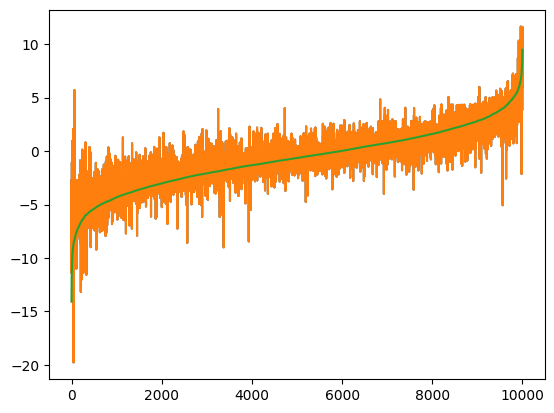

In [26]:
j = 0
sort_order = np.argsort(z[j])
plt.plot(z_hat_new[j][sort_order])
plt.plot(z_hat_old[j][sort_order])
plt.plot(z[j][sort_order])

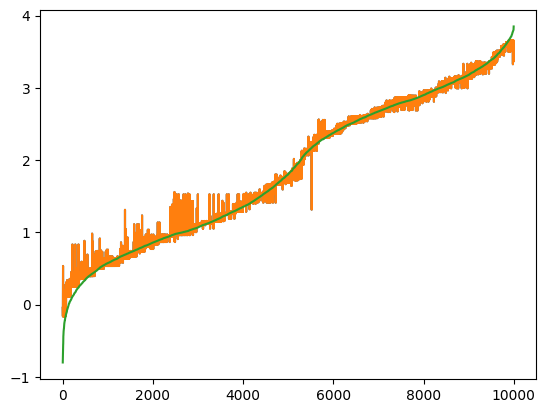

In [27]:
j = 1
sort_order = np.argsort(z[j])
plt.plot(z_hat_new[j][sort_order])
plt.plot(z_hat_old[j][sort_order])
plt.plot(z[j][sort_order])
